In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

In [4]:
prices = pd.read_csv('finaldata.csv', parse_dates=['Timestamp'], index_col='Timestamp')

prices = prices.apply(lambda col: col.abs() if col.name != 'Timestamp' else col)

In [35]:
column1_name = 'Instr3'
column2_name = 'Instr12'

# Create two separate DataFrames for each column
X1 = pd.DataFrame(prices[column1_name].copy(), columns=[column1_name])
X2 = pd.DataFrame(prices[column2_name].copy(), columns=[column2_name])

# X1 = pd.Series([1, 2, 3, 4, 5])  # Replace with your actual data
# X2 = pd.Series([5, 4, 3, 2, 1])  # Replace with your actual data

# # Convert pandas Series to NumPy arrays
# X1_array = X1.to_numpy()
# X2_array = X2.to_numpy()

# # Stack the variables horizontally to create a 2D array
# data = np.column_stack((X1_array, X2_array))

In [36]:
%config InlineBackend.figure_format = 'retina'
#az.style.use('arviz-darkgrid')
sns.set_style('darkgrid')

In [37]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    rets.iloc[0] = 0
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)

    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)

    return total_return, apr, sharpe, maxDD, maxDDD

In [38]:
def generate_par(N, rho, sigma_M, sigma_R):
    '''
    Generate PAR sample of length N with parameters rho, sigma_M, sigma_R
    '''
    from statsmodels.tsa.arima_process import arma_generate_sample

    ar_M = np.r_[1, -rho]
    ar_R = np.r_[1, -1]
    ma = np.r_[1]

    M = arma_generate_sample(ar_M, ma, N, scale=sigma_M)
    R = arma_generate_sample(ar_R, ma, N, scale=sigma_R)

    return M+R

In [39]:
def calculate_Rsq(rho, sigma_M, sigma_R):
    '''
    Calculate R^2 - proportion of variance attributable to mean reversion
    '''
    return (2*sigma_M**2) / (2*sigma_M**2 + (1+rho) * sigma_R**2)

In [40]:
def lagvar_estimate_par(X):
    '''
    estimate parameters of partial AR model using lagged variances
    '''

    # calculate lagged variances
    v1 = np.var(X[1:] - X[:-1])
    v2 = np.var(X[2:] - X[:-2])
    v3 = np.var(X[3:] - X[:-3])

    # rho
    rho_lv = -(v1 - 2*v2 + v3) / (2*v1 - v2)

    # sigma_M
    if (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1) > 0:
        sigma_M_lv = np.sqrt(1/2 * (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1))
    else:
        sigma_M_lv = 0

    # sigma_R
    if v2 > 2*sigma_M_lv**2:
        sigma_R_lv = np.sqrt(1/2 * (v2 - 2*sigma_M_lv**2))
    else:
        sigma_R_lv = 0

    return rho_lv, sigma_M_lv, sigma_R_lv

def lagvar_estimate_rw(X):
    '''
    estimate parameters of randow walk model using lagged variances
    '''

    # calculate lagged variances
    v1 = np.var(X[1:] - X[:-1])
    v2 = np.var(X[2:] - X[:-2])
    v3 = np.var(X[3:] - X[:-3])

    # rho
    rho_lv = 0
    # sigma_M
    sigma_M_lv = 0
    # sigma_R
    sigma_R_lv = np.sqrt(1/2 * (v2 - 2*sigma_M_lv**2))

    return sigma_R_lv

def lagvar_estimate_ar(X):
    '''
    estimate parameters of AR model using lagged variances
    '''

    # calculate lagged variances
    v1 = np.var(X[1:] - X[:-1])
    v2 = np.var(X[2:] - X[:-2])
    v3 = np.var(X[3:] - X[:-3])

    # rho
    rho_lv = -(v1 - 2*v2 + v3) / (2*v1 - v2)
    # sigma_M
    if (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1) > 0:
        sigma_M_lv = np.sqrt(1/2 * (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1))
    else:
        sigma_M_lv = 0

    return rho_lv, sigma_M_lv

In [41]:
def kalman_estimate(X, rho, sigma_M, sigma_R):
    '''
    Calculate estimates of mean-reverting and random walk components
    '''

    # create arrays for storing both components and prediction errors
    M = np.zeros(len(X))
    R = np.zeros(len(X))
    eps = np.zeros(len(X))

    # set initial state
    if sigma_R==0:
        M[0] = X[0]
        R[0] = 0
    else:
        M[0] = 0
        R[0] = X[0]

    # calculate Kalman gain
    if sigma_M==0:
        K_M = 0
        K_R = 1
    elif sigma_R==0:
        K_M = 1
        K_R = 0
    else:
        sqr = np.sqrt((1+rho)**2 * sigma_R**2 + 4*sigma_M**2)
        K_M = 2*sigma_M**2 / (sigma_R * (sqr + rho*sigma_R + sigma_R) + 2*sigma_M**2)
        K_R = 2*sigma_R / (sqr - rho*sigma_R + sigma_R)

    # calculate estimates
    for i in range(1, len(X)):
        xhat = rho * M[i-1] + R[i-1]
        eps[i] = X[i] - xhat
        M[i] = rho * M[i-1] + eps[i] * K_M
        R[i] = R[i-1] + eps[i] * K_R

    return M, R, eps

def log_like(X, rho, sigma_M, sigma_R):
    '''
    Compute log likelihood function
    '''

    N = len(X)
    _,_,eps = kalman_estimate(X, rho, sigma_M, sigma_R)
    ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)

    return ll

def f_to_min_par(parameters, X):
    rho, sigma_M, sigma_R = parameters
    return -log_like(X, rho, sigma_M, sigma_R)

def f_to_min_rw(sigma_R, X):
    rho = 0
    sigma_M = 0 # remove mean-reverting component
    return -log_like(X, rho, sigma_M, sigma_R)

def f_to_min_ar(parameters, X):
    rho, sigma_M = parameters
    sigma_R = 0 # remove random walk component
    return -log_like(X, rho, sigma_M, sigma_R)

from scipy.optimize import minimize
from scipy import stats

# distribution for random guesses
rnd_rho = stats.uniform(loc=-1, scale=2)

def fit_par(X, mode, tol=0.001):
    '''
    fit PAR model using MLE
    '''

    estimates = []
    lls = []

    if mode=='PAR':
        # get initial guesses using lagged variances
        x0 = lagvar_estimate_par(X)
        # set boundaries
        bounds = ((-1,1), (0,np.inf), (0,np.inf))
        # function to use in minimization
        f_to_min = f_to_min_par
        # function to generate random initial values
        std = np.std(np.diff(X))
        rnd_sigma = stats.norm(loc=std, scale=std/2)
        def gen_x0():
            return rnd_rho.rvs(), rnd_sigma.rvs(), rnd_sigma.rvs()

    elif mode=='AR':
        x0 = lagvar_estimate_ar(X)
        bounds = ((-1,1), (0,np.inf))
        f_to_min = f_to_min_ar
        std = np.std(np.diff(X))
        rnd_sigma = stats.norm(loc=std, scale=std/2)
        def gen_x0():
            return rnd_rho.rvs(), rnd_sigma.rvs()

    elif mode=='RW':
        x0 = lagvar_estimate_rw(X)
        bounds = ((0,np.inf),)
        f_to_min = f_to_min_rw
        std = np.std(np.diff(X))
        rnd_sigma = stats.norm(loc=std, scale=std/2)
        def gen_x0():
            return rnd_sigma.rvs()

    # minimize
    res = minimize(f_to_min, (x0), args=(X), bounds=bounds, tol=tol)

    if res.success:
        estimates.append(res.x)
        lls.append(-res.fun) # save log-likelihood

    # repeat minimization with different (random) initial values
    n_att = 0
    while len(lls)<10 and n_att<100:
        n_att += 1
        x0 = gen_x0()
        res = minimize(f_to_min, (x0), args=(X), bounds=bounds, tol=tol)
        if res.success:
            estimates.append(res.x)
            lls.append(-res.fun) # save log-likelihood

    try:
        argmax = np.argmax(lls) # index of the biggest likelihood
        return estimates[argmax]
    except:
        print('Estimation failed!')
        return len(x0)*[np.nan] # return nans

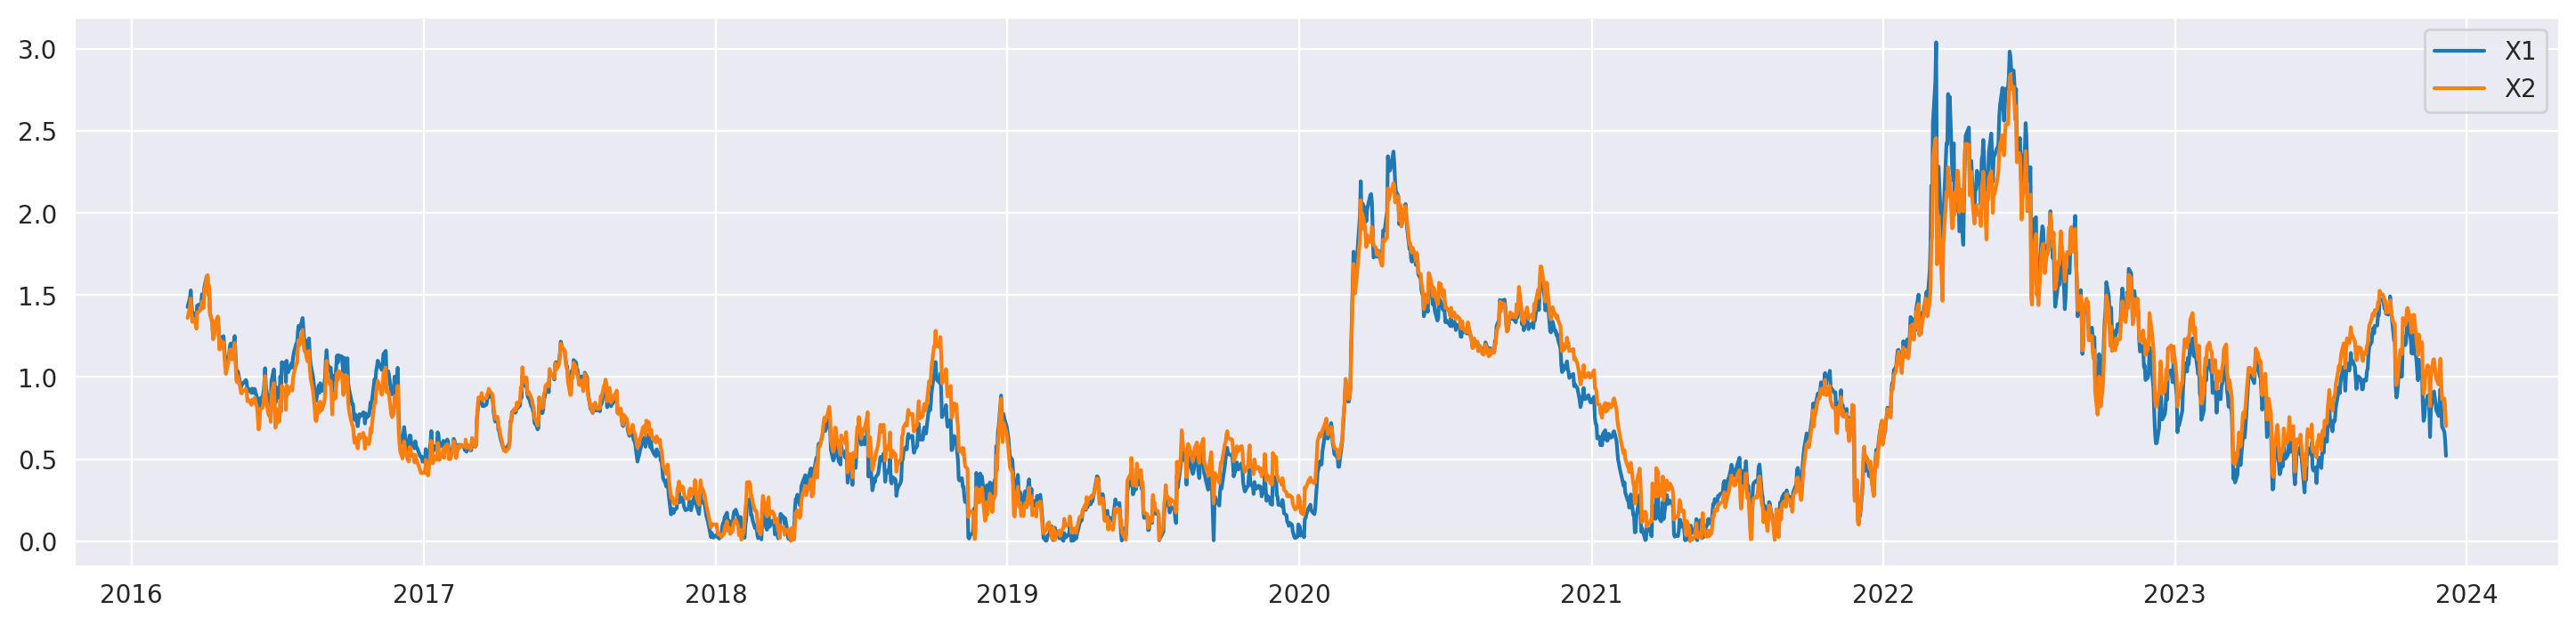

In [42]:
plt.figure(figsize=(18,4))
plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.legend()

In [43]:
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
X1 = pd.Series([1, 2, 3, 4, 5])  # Replace with your actual data
X2 = pd.Series([5, 4, 3, 2, 1])  # Replace with your actual data

# Convert pandas Series to NumPy arrays
X1_array = X1.to_numpy()
X2_array = X2.to_numpy()

# Stack the variables horizontally to create a 2D array
# data = np.column_stack((X1_array, X2_array))
# X1_diff = X1.diff().dropna()
# X2_diff = X2.diff().dropna()


In [30]:
res = coint_johansen(np.array([X1_diff,X2_diff]).T, det_order=0, k_ar_diff=1)
(res.lr2 > res.cvm[:,1]).sum() # must be 2 to reject the null at 95%

LinAlgError: ignored

In [29]:
X1 = pd.Series([1, 2, 3, 4, 5])  # Replace with your actual data
X2 = pd.Series([5, 4, 3, 2, 1])  # Replace with your actual data

# Convert pandas Series to NumPy arrays
X1_array = X1.to_numpy()
X2_array = X2.to_numpy()

# Stack the variables horizontally to create a 2D array
data = np.column_stack((X1_array, X2_array))

# Perform the Johansen cointegration test
res = coint_johansen(data, det_order=0, k_ar_diff=1)

# Check the number of eigenvalues greater than critical values
num_rejects = (res.lr2 > res.cvm[:, 1]).sum()


LinAlgError: ignored

In [44]:
coint(X2,X1)


<ipython-input-44-d2e82028fb74>:1: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  coint(X2,X1)


(-inf, 0.0, array([-8.7298525, -5.2900925, -4.27475  ]))

In [45]:
coint(X1,X2)

<ipython-input-45-3a2b96c889ee>:1: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  coint(X1,X2)


(-inf, 0.0, array([-8.7298525, -5.2900925, -4.27475  ]))

In [46]:
import statsmodels.api as sm

def fit_pci(X1, X2, mode='PAR', tol=0.001):
    '''
    fit partial cointegration model to time series X1 and X2
    X2 = alpha + beta * X1 + W
    '''

    # calculate initial guess for beta
    res = sm.OLS(np.diff(X2), np.diff(X1)).fit()
    beta0 = res.params[0]

    # calculate initial guess for alpha
    alpha0 = X2[0] - beta0 * X1[0]

    # calculate initial guesses for rho, sigma_M, sigma_R
    W = X2 - alpha0 - beta0 * X1
    params0 = fit_par(W, mode=mode)

    # perform optimization depending on the mode
    if mode=='PAR':
        def f_to_min_pci(parameters, X1, X2):
            alpha,beta,rho,sigma_M,sigma_R = parameters
            W = X2 - beta*X1 - alpha
            return -log_like(W, rho, sigma_M, sigma_R)

        x0 = (alpha0, beta0, *params0) # initial guess
        res = minimize(f_to_min_pci, x0, args=(X1, X2), tol=tol)
        alpha,beta,rho,sigma_M,sigma_R = res.x
        ll = -res.fun

    elif mode=='AR':
        def f_to_min_pci(parameters, X1, X2):
            alpha,beta,rho,sigma_M = parameters
            sigma_R = 0
            W = X2 - beta*X1 - alpha
            return -log_like(W, rho, sigma_M, sigma_R)

        x0 = (alpha0, beta0, *params0) # initial guess
        res = minimize(f_to_min_pci, x0, args=(X1, X2), tol=tol)
        alpha,beta,rho,sigma_M = res.x
        sigma_R = 0
        ll = -res.fun

    elif mode=='RW':
        def f_to_min_pci(parameters, X1, X2):
            alpha,beta,sigma_R = parameters
            rho = 0
            sigma_M = 0
            W = X2 - beta*X1 - alpha
            return -log_like(W, rho, sigma_M, sigma_R)

        x0 = (alpha0, beta0, *params0) # initial guess
        res = minimize(f_to_min_pci, x0, args=(X1, X2), tol=tol)
        alpha,beta,sigma_R = res.x
        rho = 0
        sigma_M = 0
        ll = -res.fun

    return alpha, beta, rho, sigma_M, sigma_R, ll

In [47]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    alpha_hat,beta_hat,rho_hat,sigmaM_hat,sigmaR_hat,ll = fit_pci(X1,X2, mode='PAR')

print(f'alpha = {alpha_hat}')
print(f'beta = {beta_hat}')
print(f'rho = {rho_hat}')
print(f'sigma_M = {sigmaM_hat}')
print(f'sigma_R = {sigmaR_hat}')
print(f'log-likelihood = {ll}')

Estimation failed!
alpha = 6.0
beta = -1.0
rho = nan
sigma_M = nan
sigma_R = nan
log-likelihood = nan


In [49]:
alpha = 6.0
beta = -1.0
rho = nan
sigma_M = nan
sigma_R = nan

NameError: ignored

In [48]:
calculate_Rsq(rho, sigma_M, sigma_R)


NameError: ignored